<a href="https://colab.research.google.com/github/Venkat3103/Quora-Question-Pair-NLP/blob/main/Group_11_Code_Quora_Question_Pairs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install Distance

     |████████████████████████████████| 180 kB 22.4 MB/s 
  Created wheel for Distance: filename=Distance-0.1.3-py3-none-any.whl size=16275 sha256=c2b33a7fed877d5737a4620230b55d8166ca676072c111ebfee0d233fb149b6b
  Stored in directory: /root/.cache/pip/wheels/b2/10/1b/96fca621a1be378e2fe104cfb0d160bb6cdf3d04a3d35266cc
Successfully built Distance


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc
%pylab
import re
from nltk.corpus import stopwords
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup

%matplotlib inline

Using matplotlib backend: agg
Populating the interactive namespace from numpy and matplotlib


In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
!pip install fuzzywuzzy

In [ ]:
import warnings
warnings.filterwarnings("ignore")
from fuzzywuzzy import fuzz
from sklearn.manifold import TSNE
from wordcloud import WordCloud, STOPWORDS
from os import path
from PIL import Image

In [ ]:
#importing the data
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv("/content/drive/My Drive/train.csv")

Mounted at /content/drive


In [ ]:
dataset = pd.read_csv("/content/drive/My Drive/train.csv")

In [ ]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


#EDA


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


We are given a minimal number of data fields here, consisting of:

- id:  Looks like a simple rowID
- qid{1, 2}:  The unique ID of each question in the pair
- question{1, 2}:  The actual textual contents of the questions.
- is_duplicate:  The label that we are trying to predict - whether the two questions are duplicates of each other.

##Distribution of data points among output classes

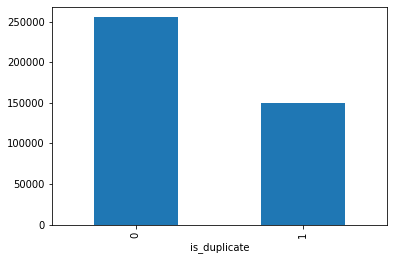

In [ ]:
df.groupby("is_duplicate")['id'].count().plot.bar()
plt.show()

In [ ]:
print("Percentage Question pairs that are not duplicates is", round(df[df['is_duplicate']==0].size/df.size *100  ,2))
print("Percentage Question pairs that are duplicates is", round(df[df['is_duplicate']==1].size/df.size *100  ,2))

Percentage Question pairs that are not duplicates is 63.08
Percentage Question pairs that are duplicates is 36.92


In [ ]:
qids= pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
unique_ids= len(np.unique(qids))
qs_morethan_onetime = np.sum(qids.value_counts() > 1)
print("Number of unique questions is ", unique_ids)
print("Number of unique questions that appear more than once is ",np.sum(qids.value_counts()>1)," (", (np.sum(qids.value_counts()>1)) /(unique_ids) *100 ,")")
print("Number of unique questions that appear more than once is ",np.max(qids.value_counts()))

q_values = qids.value_counts()

q_values= qids.values

Number of unique questions is  537933
Number of unique questions that appear more than once is  111780  ( 20.77953945937505 )
Number of unique questions that appear more than once is  157


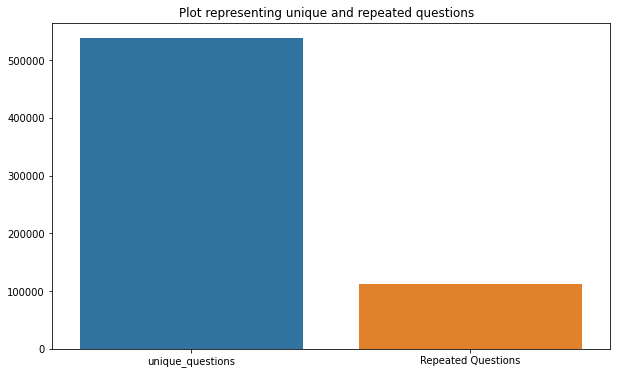

In [ ]:
x = ["unique_questions" , "Repeated Questions"]
y =  [unique_ids , qs_morethan_onetime]

plt.figure(figsize=(10, 6))
plt.title ("Plot representing unique and repeated questions  ")
sns.barplot(x,y)
plt.show()

In [ ]:
#checking whether there are any repeated pair of questions

pair_duplicates = df[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()

print ("Number of duplicate questions",(pair_duplicates).shape[0] - df.shape[0])

Number of duplicate questions 0


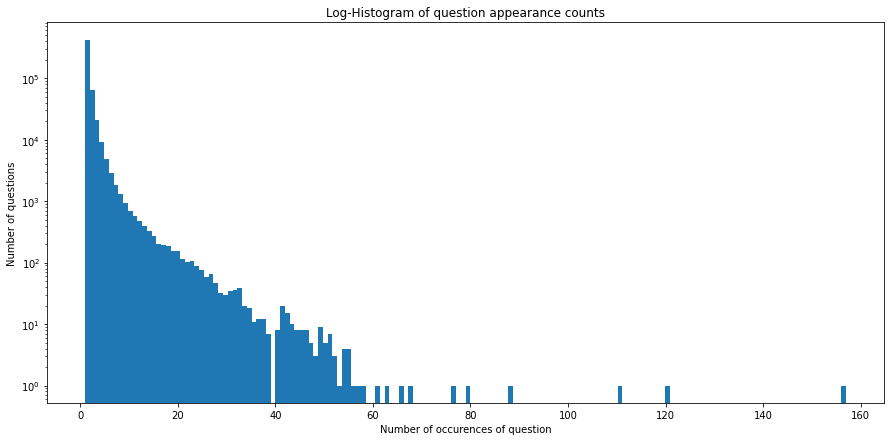

In [ ]:
#plotting a figure for the freqeuncy of different questions
plt.figure(figsize(15,7))
plt.hist( qids.value_counts(),bins=160)
plt.yscale('log',  )
plt.title('Log-Histogram of question appearance counts')

plt.xlabel('Number of occurences of question')

plt.ylabel('Number of questions')
plt.show()

In [ ]:
#dealing with null values
df[df.isnull().any(1)]

,id,qid1,qid2,question1,question2,is_duplicate
105780,105780,174363,174364,How can I develop android app?,NaN,0
201841,201841,303951,174364,How can I create an Android app?,NaN,0
363362,363362,493340,493341,NaN,My Chinese name is Haichao Yu. What English na...,0


In [ ]:
#filling an empty space inplace of Null values
df.dropna(inplace=True)
df.isnull().sum()

id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

<ul>
<li>Now we have zero rows with null values</li>
</ul>


##Basic Feature Extraction (before cleaning)

Let us now construct a few features like:
 - ____freq_qid1____ = Frequency of qid1's
 - ____freq_qid2____ = Frequency of qid2's 
 - ____q1len____ = Length of q1
 - ____q2len____ = Length of q2
 - ____q1_n_words____ = Number of words in Question 1
 - ____q2_n_words____ = Number of words in Question 2
 - ____word_Common____ = (Number of common unique words in Question 1 and Question 2)
 - ____word_Total____ =(Total num of words in Question 1 + Total num of words in Question 2)
 - ____word_share____ = (word_common)/(word_Total)
 - ____freq_q1+freq_q2____ = sum total of frequency of qid1 and qid2 
 - ____freq_q1-freq_q2____ = absolute difference of frequency of qid1 and qid2 

In [ ]:
temp1 = df[df['is_duplicate']==0] # non duplicate
temp2 = df[df['is_duplicate']==1]
temp1 = temp1.sample(n=5000)
temp2 = temp2.sample(n=5000)
df = pd.concat([temp1, temp2], ignore_index=True)
df.shape

(10000, 6)

In [ ]:
df = df.sample(frac=1).reset_index(drop=True)

In [ ]:
#contructing the features
df['freq_qid1'] = df.groupby('qid1')['qid1'].transform('count')
df['freq_qid2'] = df.groupby('qid2')['qid2'].transform('count')
df['q1len'] = df['question1'].str.len() 
df['q2len'] = df['question2'].str.len()
df['q1_n_words'] = df['question1'].apply(lambda row : len(str(row).split(' ')))
df['q2_n_words'] = df['question2'].apply(lambda row : len(str(row).split(' ')))

def normalized_word_Common(row):
        w1 = set(map(lambda word: word.lower().strip(), str(row['question1']).split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), str(row['question2']).split(" ")))    
        return 1.0 * len(w1 & w2)

df['word_Common'] = df.apply(normalized_word_Common, axis=1)

def normalized_word_Total(row):
        w1 = set(map(lambda word: word.lower().strip(), str(row['question1']).split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), str(row['question2']).split(" ")))    
        return 1.0 * (len(w1) + len(w2))
df['word_Total'] = df.apply(normalized_word_Total, axis=1)

def normalized_word_share(row):
        w1 = set(map(lambda word: word.lower().strip(), str(row['question1']).split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), str(row['question2']).split(" ")))    
        return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
df['word_share'] = df.apply(normalized_word_share, axis=1)

df['freq_q1+q2'] = df['freq_qid1']+df['freq_qid2']
df['freq_q1-q2'] = abs(df['freq_qid1']-df['freq_qid2'])

df.to_csv("df_fe_without_preprocessing_train.csv", index=False)

df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,74102,127052,127053,What if I don't attend the orientation day of ...,What if I don't attend the orientation day of ...,1,1,1,150,146,27,26,23.0,49.0,0.469388,2,0
1,378597,278771,510004,"What are the worst ""Oops!"" moments in history?",What is the worst moment in British history?,0,1,1,46,44,8,8,5.0,16.0,0.312500,2,0
2,7487,14626,14627,How do girls feel when they are squirting?,How does it feel for a woman to squirt?,1,1,1,42,39,8,9,2.0,17.0,0.117647,2,0
3,382695,514580,514581,Why we can't send files in iOS (Apple phone) e...,How come iPads or phones can't get viruses as ...,0,1,1,52,66,10,12,1.0,21.0,0.047619,2,0
4,42543,76647,76648,What is difference between love and addiction?,What is the difference between love and addict...,1,1,1,46,50,7,8,7.0,15.0,0.466667,2,0


<ul><li>Here are some questions have only one single words.</li>
</ul>

In [ ]:
print ("Minimum length of the questions in question1 : " , min(df['q1_n_words']))

print ("Minimum length of the questions in question2 : " , min(df['q2_n_words']))

print ("Number of Questions with minimum length [question1] :", df[df['q1_n_words']== 1].shape[0])
print ("Number of Questions with minimum length [question2] :", df[df['q2_n_words']== 1].shape[0])

Minimum length of the questions in question1 :  1
Minimum length of the questions in question2 :  3
Number of Questions with minimum length [question1] : 1
Number of Questions with minimum length [question2] : 0


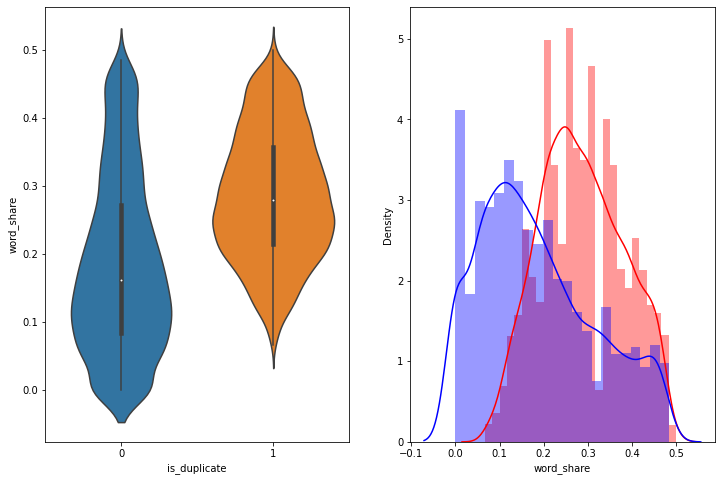

In [ ]:
#plot for feature word share
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_share', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_share'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_share'][0:] , label = "0" , color = 'blue' )
plt.show()

- The distributions for normalized word_share have some overlap on the far right-hand side, i.e., there are quite a lot of questions with high word similarity
- The average word share and Common no. of words of qid1 and qid2 is more when they are duplicate(Similar)

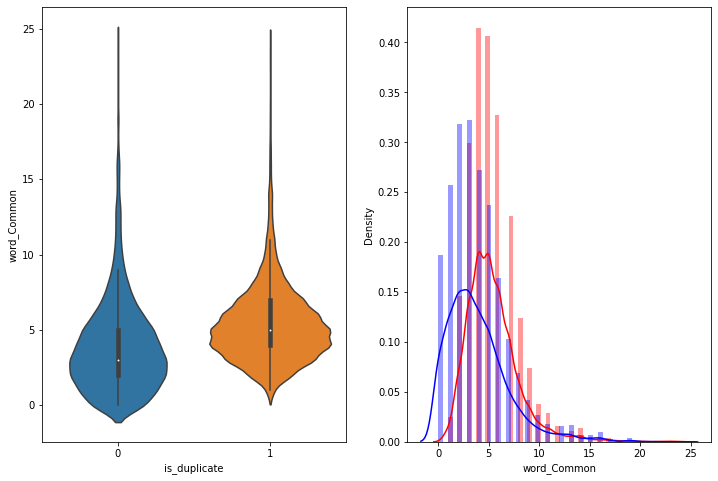

In [ ]:
#plot for feature common word
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_Common', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_Common'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_Common'][0:] , label = "0" , color = 'blue' )
plt.show()

<p> The distributions of the word_Common feature in similar and non-similar questions are highly overlapping </p>

## Preprocessing:
    - Removing html tags 
    - Removing Punctuations
    - Performing stemming
    - Removing Stopwords
    - Expanding contractions etc.

In [ ]:
# To get the results in 4 decimal points
SAFE_DIV = 0.0001 

STOP_WORDS = stopwords.words("english")


def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    
    porter = PorterStemmer()
    pattern = re.compile('\W')
    
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    
    
    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()
    return x

Advanced NLP and Fuzzy Features:
- __cwc_min__ :  Ratio of common_word_count to min lenghth of word count of Q1 and Q2 <br>cwc_min = common_word_count / (min(len(q1_words), len(q2_words))
<br>
- __cwc_max__ :  Ratio of common_word_count to max lenghth of word count of Q1 and Q2 <br>cwc_max = common_word_count / (max(len(q1_words), len(q2_words))
<br>
- __csc_min__ :  Ratio of common_stop_count to min lenghth of stop count of Q1 and Q2 <br> csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops))
<br>
- __csc_max__ :  Ratio of common_stop_count to max lenghth of stop count of Q1 and Q2<br>csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops))
<br>
c_min__ :  Ratio of common_token_count to min lenghth of token count of Q1 and Q2<br>ctc_min = common_token_count / (min(len(q1_tokens), len(q2_tokens))
<br>
- __ctc_max__ :  Ratio of common_token_count to max lenghth of token count of Q1 and Q2<br>ctc_max = common_token_count / (max(len(q1_tokens), len(q2_tokens))
<br>  
- __last_word_eq__ :  Check if First word of both questions is equal or not<br>last_word_eq = int(q1_tokens[-1] == q2_tokens[-1])
<br>
- __first_word_eq__ :  Check if First word of both questions is equal or not<br>first_word_eq = int(q1_tokens[0] == q2_tokens[0])
<br>    
- __abs_len_diff__ :  Abs. length difference<br>abs_len_diff = abs(len(q1_tokens) - len(q2_tokens))
<br>
- __mean_len__ :  Average Token Length of both Questions<br>mean_len = (len(q1_tokens) + len(q2_tokens))/2
<br>
- __fuzz_ratio__ :  String similarity - the ratio of similarity between Q1 and Q2 whose value lies between 0 and 100.
<br>
- __fuzz_partial_ratio__ :  Partial String Similarity - the ratio of the most similar substring between Q1 and Q2 as a number between 0 and 100.
<br>
- __token_sort_ratio__ : Tokenizing the string (Q1 or Q2), sorting the tokens alphabetically, and then joining them back into a string to find the string similarity ratio between the two. Value lies between 0 and 100.
<br>
- __token_set_ratio__ : All tokens of both strings (Q1 and Q2) are taken and the ratio between the sorted intersection and sorted remainder is calculated. Value lies between 0 and 100.
<br>
- __longest_substr_ratio__ :  Ratio of length longest common substring to min lenghth of token count of Q1 and Q2<br>longest_substr_ratio = len(longest common substring) / (min(len(q1_tokens), len(q2_tokens))

In [ ]:
def get_token_features(q1,q2):
   token_features =[0.0] *10
   #converting the sentence into tokens
   q1_tokens= q1.split()
   q2_tokens= q2.split()

   if len(q1_tokens) == 0 or len(q2_tokens) ==0 :
    return token_features
  #Get non-stopwords in questions
   q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
   q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
   #Get the stopwords in Questions
   q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
   q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])

   # Get the common non-stopwords from Question pair
   common_word_count = len(q1_words.intersection(q2_words))

   # Get the common stopwords from Question pair
   common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
   common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))

   token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
   token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
   token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
   token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
   token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
   token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)

   # Last word of both question is same or not
   token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
   token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
   token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    
   #Average Token Length of both Questions
   token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
   return token_features

def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)



def extract_features(df):
    # preprocessing each question
    df["question1"] = df["question1"].fillna("").apply(preprocess)
    df["question2"] = df["question2"].fillna("").apply(preprocess)

    print("token features...")
    
    # Merging Features with dataset
    
    token_features = df.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)
    
    df["cwc_min"]       = list(map(lambda x: x[0], token_features))
    df["cwc_max"]       = list(map(lambda x: x[1], token_features))
    df["csc_min"]       = list(map(lambda x: x[2], token_features))
    df["csc_max"]       = list(map(lambda x: x[3], token_features))
    df["ctc_min"]       = list(map(lambda x: x[4], token_features))
    df["ctc_max"]       = list(map(lambda x: x[5], token_features))
    df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    df["mean_len"]      = list(map(lambda x: x[9], token_features))


    print("fuzzy features..")

    df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    df["longest_substr_ratio"]  = df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)
    return df

In [ ]:
df2 = extract_features(df)
df2.to_csv("nlp_features_train.csv", index=False)

token features...
fuzzy features..


In [ ]:
df2.shape

(10000, 32)

In [ ]:
df2.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,74102,127052,127053,what if i do not attend the orientation day of...,what if i do not attend the orientation day of...,1,1,1,150,146,27,26,23.0,49.0,0.469388,2,0,0.923070,0.857137,0.999992,0.999992,0.857140,0.827583,0.0,1.0,1.0,28.5,98,97,97,100,0.993007
1,378597,278771,510004,what are the worst oops moments in history,what is the worst moment in british history,0,1,1,46,44,8,8,5.0,16.0,0.312500,2,0,0.499988,0.499988,0.749981,0.749981,0.624992,0.624992,1.0,1.0,0.0,8.0,80,80,75,73,0.244444


- Creating Word Cloud of Duplicates and Non-Duplicates Question pairs
- We can observe the most frequent occuring words

In [ ]:
df_duplicate = df2[df2['is_duplicate'] == 1]
dfp_nonduplicate = df2[df2['is_duplicate'] == 0]

# Converting 2d array of q1 and q2 and flatten the array: like {{1,2},{3,4}} to {1,2,3,4}
p = np.dstack([df_duplicate["question1"], df_duplicate["question2"]]).flatten()
n = np.dstack([dfp_nonduplicate["question1"], dfp_nonduplicate["question2"]]).flatten()

print ("Number of data points in class 1 (duplicate pairs) :",len(p))
print ("Number of data points in class 0 (non duplicate pairs) :",len(n))

#Saving the np array into a text file
np.savetxt('train_p.txt', p, delimiter=' ', fmt='%s')
np.savetxt('train_n.txt', n, delimiter=' ', fmt='%s')

Number of data points in class 1 (duplicate pairs) : 10000
Number of data points in class 0 (non duplicate pairs) : 10000


In [ ]:
df_duplicate.shape

(5000, 32)

In [ ]:
dfp_nonduplicate.shape

(5000, 32)

In [ ]:
# reading the text files and removing the Stop Words:
d = path.dirname('.')

textp_w = open(path.join(d, 'train_p.txt')).read()
textn_w = open(path.join(d, 'train_n.txt')).read()
stopwords = set(STOPWORDS)
stopwords.add("said")
stopwords.add("br")
stopwords.add(" ")
stopwords.remove("not")
stopwords.remove("no")
stopwords.remove("like")

print ("Total number of words in duplicate pair questions :",len(textp_w))
print ("Total number of words in non duplicate pair questions :",len(textn_w))

Total number of words in duplicate pair questions : 537482
Total number of words in non duplicate pair questions : 646420


**Word Clouds generated from  duplicate pair question's text**

Word Cloud for Duplicate Question pairs


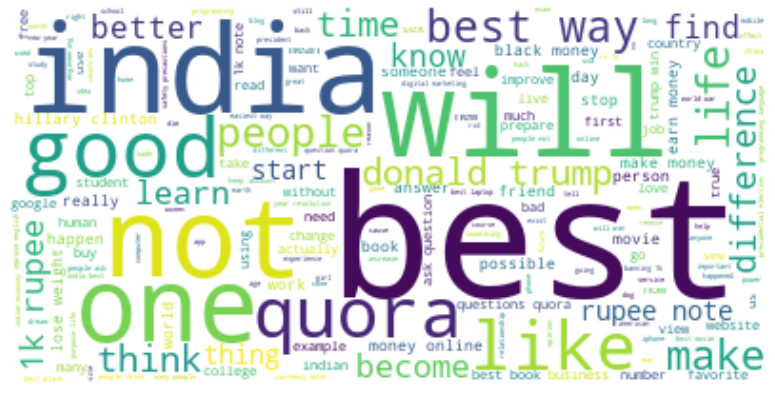

In [ ]:
wc = WordCloud(background_color="white", max_words=len(textp_w), stopwords=stopwords)
wc.generate(textp_w)
print ("Word Cloud for Duplicate Question pairs")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

Word Cloud for Duplicate Question pairs


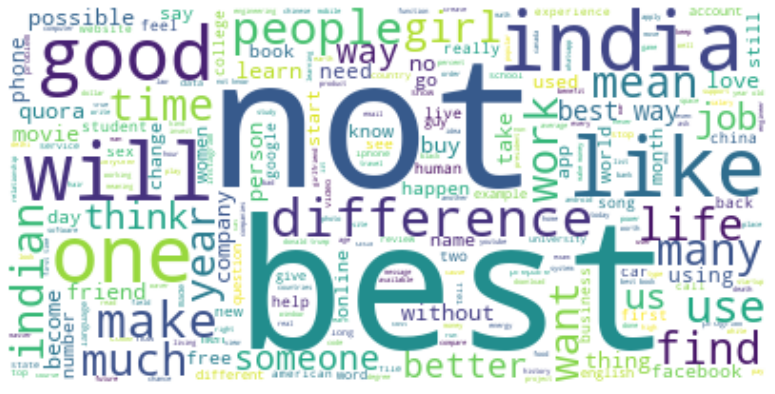

In [ ]:
wc = WordCloud(background_color="white", max_words=len(textn_w), stopwords=stopwords)
wc.generate(textn_w)
print ("Word Cloud for Duplicate Question pairs")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

### Pair plot of features ['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio']

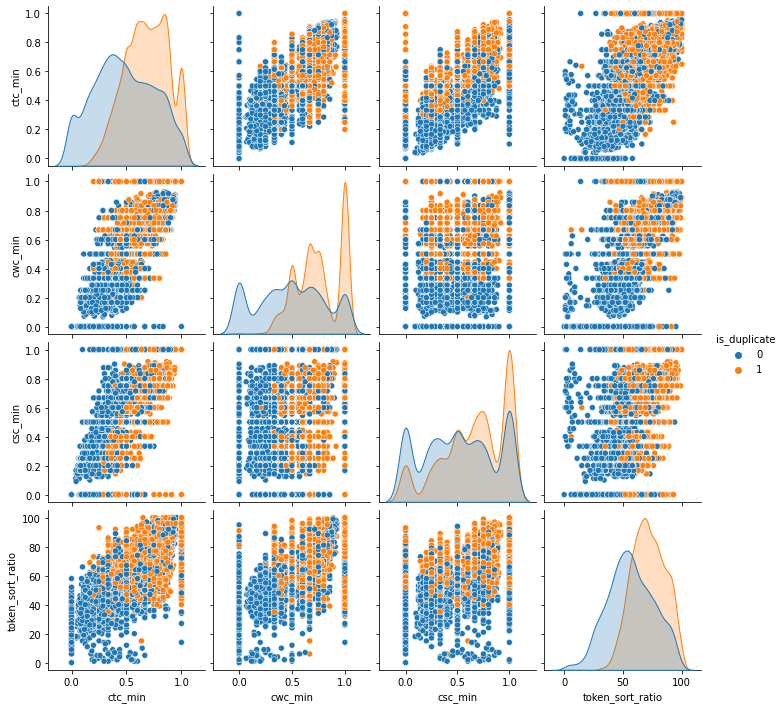

In [ ]:
n = df2.shape[0]
sns.pairplot(df2[['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio', 'is_duplicate']][0:n], hue='is_duplicate', vars=['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'])
plt.show()

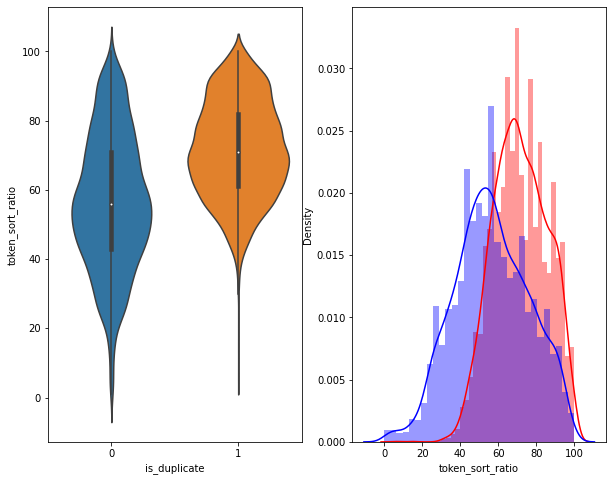

In [ ]:
# Distribution of the token_sort_ratio
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'token_sort_ratio', data = df2[0:] , )

plt.subplot(1,2,2)
sns.distplot(df2[df2['is_duplicate'] == 1.0]['token_sort_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df2[df2['is_duplicate'] == 0.0]['token_sort_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

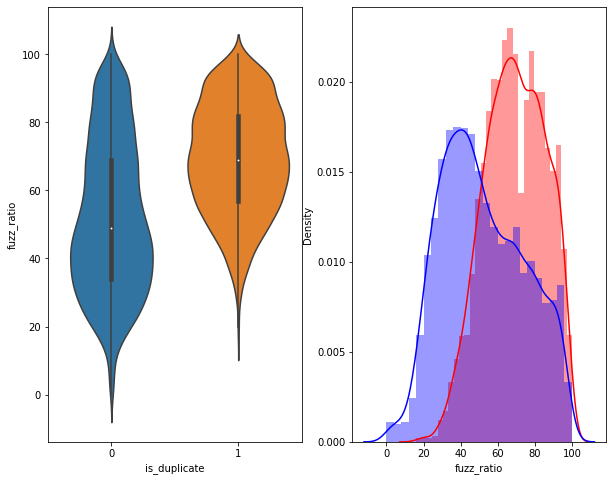

In [ ]:
# Distribution of the fuzz_ratio
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'fuzz_ratio', data = df2[0:] , )

plt.subplot(1,2,2)
sns.distplot(df2[df2['is_duplicate'] == 1.0]['fuzz_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df2[df2['is_duplicate'] == 0.0]['fuzz_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

In [ ]:
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
from tqdm import tqdm
import spacy

In [ ]:
df3 = dataset.copy()

df3['question1'] = df3['question1'].apply(lambda x: str(x))
df3['question2'] = df3['question2'].apply(lambda x: str(x))
df3.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [ ]:
temp_df = pd.DataFrame(df2.id, index= df2.index)
temp_df = temp_df.merge(df3, on='id',how='inner')

In [ ]:
# merge texts
questions = list(temp_df['question1']) + list(temp_df['question2'])

tfidf = TfidfVectorizer(lowercase=False,)
tfidf.fit_transform(questions)

# dict key:word and value:tf-idf score
word2tfidf = dict(zip(tfidf.get_feature_names(), tfidf.idf_))

- After we find TF-IDF scores, we convert each question to a weighted average of word2vec vectors by these scores.
- here we use a pre-trained GLOVE model which comes free with "Spacy".  https://spacy.io/usage/vectors-similarity
- It is trained on Wikipedia and therefore, it is stronger in terms of word semantics. 

In [ ]:
# en_vectors_web_lg, which includes over 1 million unique vectors.
nlp = spacy.load('en_core_web_sm')

vecs1 = []
for qu1 in tqdm(list(temp_df['question1'])):
    doc1 = nlp(qu1) 
    # 384 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)
df2['q1_feats_m'] = list(vecs1)

100%|██████████| 10000/10000 [01:48<00:00, 92.49it/s]


In [ ]:
vecs2 = []
for qu2 in tqdm(list(temp_df['question2'])):
    doc2 = nlp(qu2) 
    mean_vec2 = np.zeros([len(doc1), len(doc2[0].vector)])
    for word2 in doc2:
        # word2vec
        vec2 = word2.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word2)]
        except:
            #print word
            idf = 0
        # compute final vec
        mean_vec2 += vec2 * idf
    mean_vec2 = mean_vec2.mean(axis=0)
    vecs2.append(mean_vec2)
df2['q2_feats_m'] = list(vecs2)

100%|██████████| 10000/10000 [01:46<00:00, 94.28it/s]


In [ ]:
dfnlp = pd.read_csv("nlp_features_train.csv",encoding='latin-1')
dfppro = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')

In [ ]:
df = df2.copy()

In [ ]:
df1 = dfnlp.drop(['qid1','qid2','question1','question2','freq_qid1','freq_qid2','q1len','q2len','q1_n_words','q2_n_words','word_Common','word_Total','word_share','freq_q1+q2','freq_q1-q2'],axis=1)
df2 = dfppro.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
df3 = df.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
df3_q1 = pd.DataFrame(df3.q1_feats_m.values.tolist(), index= df3.index)
df3_q2 = pd.DataFrame(df3.q2_feats_m.values.tolist(), index= df3.index)

In [ ]:
df1.head()

,id,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,74102,1,0.923070,0.857137,0.999992,0.999992,0.857140,0.827583,0.0,1.0,1.0,28.5,98,97,97,100,0.993007
1,378597,0,0.499988,0.499988,0.749981,0.749981,0.624992,0.624992,1.0,1.0,0.0,8.0,80,80,75,73,0.244444
2,7487,1,0.333322,0.333322,0.199996,0.166664,0.249997,0.222220,0.0,1.0,1.0,8.5,68,68,63,62,0.175000
3,382695,0,0.166664,0.142855,0.399992,0.399992,0.272725,0.230767,0.0,0.0,2.0,12.0,57,51,40,47,0.163636
4,42543,1,0.999967,0.999967,0.999975,0.799984,0.999986,0.874989,1.0,1.0,1.0,7.5,100,96,96,91,0.829787


In [ ]:
df2.head()

,id,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,74102,1,1,150,146,27,26,23.0,49.0,0.469388,2,0
1,378597,1,1,46,44,8,8,5.0,16.0,0.312500,2,0
2,7487,1,1,42,39,8,9,2.0,17.0,0.117647,2,0
3,382695,1,1,52,66,10,12,1.0,21.0,0.047619,2,0
4,42543,1,1,46,50,7,8,7.0,15.0,0.466667,2,0


In [ ]:
df3_q1.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95
0,89.515029,3.679894,-123.333454,135.941882,180.831731,91.783630,45.635717,-49.955296,287.142869,258.567734,67.548802,-61.481649,-30.425520,-123.541842,-112.823602,-66.909849,-41.190217,119.932362,-12.409031,-118.754342,50.777808,37.480621,32.628520,-3.531897,-130.315591,-19.871830,-15.081223,-73.010640,132.362246,-160.684105,45.616681,70.091073,10.842773,-222.914962,-128.224488,-149.359749,173.603609,-229.127711,-290.916557,-2.853403,...,54.866495,236.713213,-65.396741,45.517940,145.536814,-100.118612,61.043291,176.581418,122.477068,13.305832,76.800523,-209.842610,-125.616325,116.888755,-102.851713,103.110072,104.150939,-18.556379,-26.558205,-14.108325,114.689262,-106.340578,-74.932415,-24.334181,97.796552,-108.980236,-17.483255,-11.523873,172.459127,3.303942,-12.099717,-25.334880,-141.770747,113.089882,-19.052281,30.140086,43.436072,157.874482,170.494830,49.397855
1,9.821676,-45.364574,-1.977662,-1.356916,105.586155,44.470914,26.317903,0.069159,34.409840,31.415022,-40.399214,-12.639640,30.398865,71.291496,70.502084,0.995883,-73.300666,36.710613,58.985134,-72.248755,82.605851,-24.127719,-47.478299,-37.568727,8.676213,3.609164,-96.410790,-4.920512,24.691071,56.891225,-0.567243,47.237762,-19.084818,-33.800521,42.868577,5.799026,19.334029,47.824905,-13.934540,-51.463013,...,48.311049,46.659664,-16.832819,17.567873,57.819926,42.167257,-36.491718,31.805568,-13.098928,-1.786904,10.741910,-68.616759,-38.262399,30.441636,-38.969171,-20.895079,78.607563,26.261454,-14.882843,-34.087835,23.093776,-76.550812,35.855335,14.356109,28.784345,13.484284,-9.534839,37.383881,3.933521,-36.257635,-46.340869,18.446350,-39.059704,16.339267,23.474183,29.376884,6.526654,40.137230,6.252597,22.165820
2,34.116456,49.049026,-36.589056,-94.054131,27.439761,-53.254442,73.689986,58.521065,62.001313,63.406963,-88.227627,27.549527,47.110553,-41.379125,-28.812986,7.278558,-39.675679,-26.183051,35.898430,7.310172,32.048403,41.385709,-0.973905,-16.625911,-2.830666,2.933966,-2.470089,-74.232959,14.793549,49.832997,72.626604,31.339248,29.050399,-41.348187,73.604265,-45.052585,-13.170693,-12.711776,-70.722254,-38.137078,...,31.890721,0.703269,46.068878,27.177388,108.596761,-43.230679,-20.878531,55.968577,-11.544168,-63.478884,1.993121,-20.314981,-3.436211,40.490069,-61.729980,-13.900605,62.784386,10.881335,29.029857,3.036794,73.876942,-109.109040,-2.242734,-17.489261,-49.145431,48.924644,-77.948331,32.034345,33.793277,-38.715097,5.162318,-10.533508,-35.216327,67.548961,-58.488425,-63.545894,-27.023968,9.283041,-24.731358,39.284242
3,-54.472201,-8.205257,-66.551617,-57.805192,69.381212,-16.494790,167.804315,64.306500,82.505878,68.079874,-3.510798,10.189255,9.213183,-9.783941,19.547230,-13.849110,-21.764399,2.416103,-8.089059,-15.508846,-26.314617,-0.768347,-69.802464,-23.886283,-16.831609,7.875989,25.116197,1.106867,3.778245,-27.540096,78.296551,-21.723459,-3.780621,-65.781377,53.960379,5.035422,63.646446,9.419099,-136.069605,8.734619,...,86.796600,35.989477,58.371676,11.788019,29.099584,-40.015452,0.177420,22.367173,59.258383,-26.326651,32.162005,-4.203544,-9.076181,70.545010,-60.387831,4.662657,86.778075,-28.450503,56.851712,-49.151875,119.532990,-86.115516,-53.765751,48.915003,-75.789457,-30.028812,-30.788381,9.346532,31.872510,-48.233720,34.193230,-35.452176,-36.575984,26.377731,-42.399872,-65.903654,-43.816105,93.327072,-27.900715,69.432568
4,-40.118682,38.138655,-9.790981,-37.389376,79.030374,-11.524096,-2.253733,0.297895,29.815157,116.057059,-19.331708,4.820058,-15.032257,-45.461508,-22.222081,-21.731483,-27.600416,5.739054,18.172988,-7.369957,81.466131,35.249640,14.533766,1.166515,-48.402070,7.401304,-2.333184,-3.793597,50.394359,-15.828856,-0.423047,3.105371,-17.057986,2.050060,-26.924451,-37.002715,14.421572,-3.682728,1.967478

In [ ]:
print("Number of features in nlp dataframe :", df1.shape[1])
print("Number of features in preprocessed dataframe :", df2.shape[1])
print("Number of features in question1 w2v  dataframe :", df3_q1.shape[1])
print("Number of features in question2 w2v  dataframe :", df3_q2.shape[1])
print("Number of features in final dataframe  :", df1.shape[1]+df2.shape[1]+df3_q1.shape[1]+df3_q2.shape[1]-1)

Number of features in nlp dataframe : 17
Number of features in preprocessed dataframe : 12
Number of features in question1 w2v  dataframe : 96
Number of features in question2 w2v  dataframe : 96
Number of features in final dataframe  : 220


In [ ]:
df.shape

(10000, 34)

In [ ]:
df1.shape

(10000, 17)

In [ ]:
df2.shape

(10000, 12)

In [ ]:
df3.shape

(10000, 29)

In [ ]:
df3_q1.shape

(10000, 96)

In [ ]:
df3_q2.shape

(10000, 96)

In [ ]:
df3_q1['id'] = df1['id']
df3_q2['id'] = df1['id']
df1 = df1.merge(df2, on='id',how='left')
df2 = df3_q1.merge(df3_q2, on='id',how='left')
result = df1.merge(df2, on='id',how='left')
result.to_csv('final_features.csv')

In [ ]:
result.columns

Index(['id', 'is_duplicate', 'cwc_min', 'cwc_max', 'csc_min', 'csc_max',
       'ctc_min', 'ctc_max', 'last_word_eq', 'first_word_eq',
       ...
       '86_y', '87_y', '88_y', '89_y', '90_y', '91_y', '92_y', '93_y', '94_y',
       '95_y'],
      dtype='object', length=220)

In [ ]:
result.drop('id',axis=1,inplace=True)

In [ ]:
result.shape

(10000, 219)

In [ ]:
result.head()

,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,10_x,11_x,12_x,...,56_y,57_y,58_y,59_y,60_y,61_y,62_y,63_y,64_y,65_y,66_y,67_y,68_y,69_y,70_y,71_y,72_y,73_y,74_y,75_y,76_y,77_y,78_y,79_y,80_y,81_y,82_y,83_y,84_y,85_y,86_y,87_y,88_y,89_y,90_y,91_y,92_y,93_y,94_y,95_y
0,1,0.923070,0.857137,0.999992,0.999992,0.857140,0.827583,0.0,1.0,1.0,28.5,98,97,97,100,0.993007,1,1,150,146,27,26,23.0,49.0,0.469388,2,0,89.515029,3.679894,-123.333454,135.941882,180.831731,91.783630,45.635717,-49.955296,287.142869,258.567734,67.548802,-61.481649,-30.425520,...,54.041136,235.751491,-60.742286,11.349582,116.377251,-35.034871,86.223284,167.579489,146.146999,7.637233,119.476551,-207.383744,-101.256808,69.401190,-59.217396,76.592464,102.252731,-18.608419,15.244332,-19.715366,93.400101,-129.491161,-86.076927,-56.233211,77.896488,-39.094772,7.168294,27.775453,153.866749,-1.771250,-35.298781,-71.072736,-145.947275,95.389505,-50.290240,-6.168822,61.823755,93.134756,136.887338,91.155245
1,0,0.499988,0.499988,0.749981,0.749981,0.624992,0.624992,1.0,1.0,0.0,8.0,80,80,75,73,0.244444,1,1,46,44,8,8,5.0,16.0,0.312500,2,0,9.821676,-45.364574,-1.977662,-1.356916,105.586155,44.470914,26.317903,0.069159,34.409840,31.415022,-40.399214,-12.639640,30.398865,...,26.430627,54.521280,-46.868794,12.798632,-20.848835,-34.456205,26.133620,89.597535,50.069246,2.656255,84.955009,-79.874647,-48.867342,32.966669,-12.551466,-61.278363,18.830658,35.679052,12.294768,-15.818330,81.704714,-34.875900,6.993764,49.230343,33.314897,-58.331210,13.532182,68.683288,-0.789609,-18.070270,-19.727546,-45.255203,-30.056019,23.294090,-22.381133,8.320436,-25.774998,31.119835,20.694769,16.694901
2,1,0.333322,0.333322,0.199996,0.166664,0.249997,0.222220,0.0,1.0,1.0,8.5,68,68,63,62,0.175000,1,1,42,39,8,9,2.0,17.0,0.117647,2,0,34.116456,49.049026,-36.589056,-94.054131,27.439761,-53.254442,73.689986,58.521065,62.001313,63.406963,-88.227627,27.549527,47.110553,...,93.800810,-42.893306,17.632178,15.753549,21.315864,-61.967539,90.113984,-48.154237,-0.134831,-72.438391,55.965067,48.466328,-44.029182,16.172158,-25.051241,26.245390,-17.094953,-21.337327,-36.227442,5.981121,43.823730,-80.261343,-46.996501,-3.272871,-26.280256,10.323248,-75.009874,35.101043,-22.735233,-77.673035,-33.690230,29.613025,-18.824560,13.027252,-18.288887,-9.108483,-15.626655,6.880931,-24.864630,-17.725631
3,0,0.166664,0.142855,0.399992,0.399992,0.272725,0.230767,0.0,0.0,2.0,12.0,57,51,40,47,0.163636,1,1,52,66,10,12,1.0,21.0,0.047619,2,0,-54.472201,-8.205257,-66.551617,-57.805192,69.381212,-16.494790,167.804315,64.306500,82.505878,68.079874,-3.510798,10.189255,9.213183,...,7.933301,58.627900,24.943552,15.872635,29.869870,155.418685,12.522677,-10.570077,141.925236,-37.920502,48.701192,-1.030357,106.768517,-16.512995,-60.670858,-45.666821,89.698930,-6.594856,-60.964005,-85.947595,134.665635,-69.633450,-116.888179,-62.806816,-116.487400,87.859942,-51.559986,28.276188,-34.001996,-113.604155,36.037897,50.716749,-107.209832,51.932833,-25.763862,-45.065531,136.186517,5.560879,45.558250,142.236353
4,1,0.999967,0.999967,0.999975,0.799984,0.999986,0.874989,1.0,1.0,1.0,7.5,100,96,96,91,0.829787,1,1,46,50,7,8,7.0,15.0,0.466667,2,0,-40.118682,38.138655,-9.790981,-37.389376,79.030374,-11.524096,-2.253733,0.297895,29.815157,116.057059,-19.331708,4.820058,-15.032257,...,31.515131,9.290436,0.732139,57.332215,50.534401,-36.409117,10.598228,38.218482,-12.527625,-36.935882,37.330751,-66.119991,-13.131488,24.242471,-19.041770,-12.224716,47.643946,-2.505843,-19.981993,3.762813,31.448854,-22.837925,1.664700,-42.797591,6.169668,-19.921830,-24.209419,13.623260,-17.049559,-0.956550,9.960139,-0.859081,-34.557148,12.094748,-32.762393,20.985120,-14.980305,60.243968,66.733

#Train Test Split

In [ ]:
pip install scikit-learn scipy matplotlib

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import csv
import os
warnings.filterwarnings("ignore")
import datetime as dt
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV


from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
# from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve

In [ ]:
y_true = result['is_duplicate']
result.drop(['is_duplicate'],axis=1,inplace=True)
X_train,X_test, y_train, y_test = train_test_split(result, y_true, stratify=y_true, test_size=0.3)

In [ ]:
print("Number of data points in train data :",X_train.shape)
print("Number of data points in test data :",X_test.shape)

Number of data points in train data : (7000, 218)
Number of data points in test data : (3000, 218)


In [ ]:
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in test data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[0])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.5 Class 1:  0.5
---------- Distribution of output variable in test data ----------
Class 0:  0.5 Class 1:  0.5


In [ ]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))

    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

##Building a random model (Finding worst-case log-loss)

---



In [ ]:
pip install scikit-plot

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

Log loss on Test Data using Random Model 0.8859396599628738


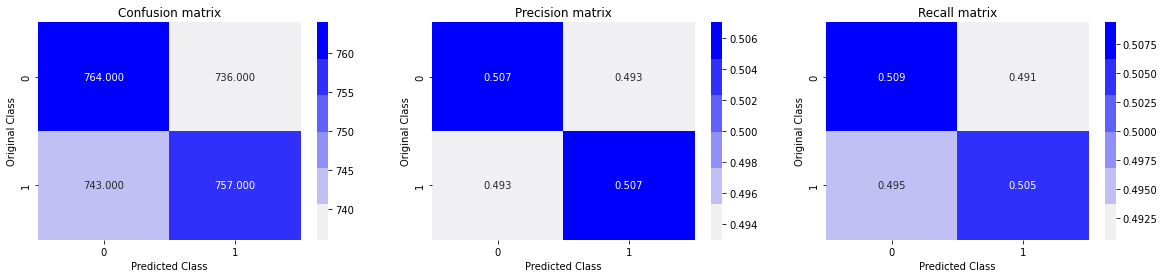

In [ ]:
import scikitplot.metrics as skplt

# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# we create a output array that has exactly same size as the CV data
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))
predicted_y =np.argmax(predicted_y, axis=1)

plot_confusion_matrix(y_test, predicted_y)
plt.show()

In [ ]:
print("Classification Report\n",classification_report(y_test,predicted_y))

Classification Report
               precision    recall  f1-score   support

           0       0.51      0.51      0.51      1500
           1       0.51      0.50      0.51      1500

    accuracy                           0.51      3000
   macro avg       0.51      0.51      0.51      3000
weighted avg       0.51      0.51      0.51      3000



##Logistic Regression with hyperparameter tuning

For values of alpha =  1e-05 The log loss is: 0.6931471805599454
For values of alpha =  0.0001 The log loss is: 0.6041576405157286
For values of alpha =  0.001 The log loss is: 0.5980905180495573
For values of alpha =  0.01 The log loss is: 0.6157636396786017
For values of alpha =  0.1 The log loss is: 0.5822468473652618
For values of alpha =  1 The log loss is: 0.5707969086590421
For values of alpha =  10 The log loss is: 0.5732724299737526


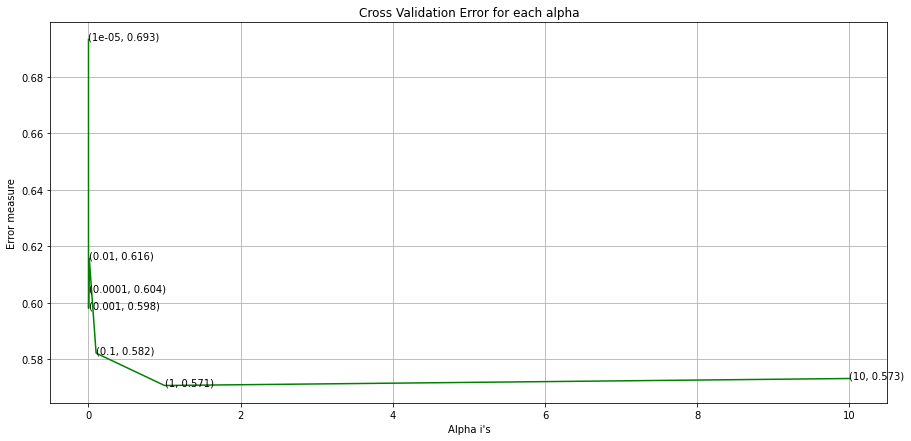

For values of best alpha =  1 The train log loss is: 0.5600044660926322
For values of best alpha =  1 The test log loss is: 0.5707969086590421
Total number of data points : 3000


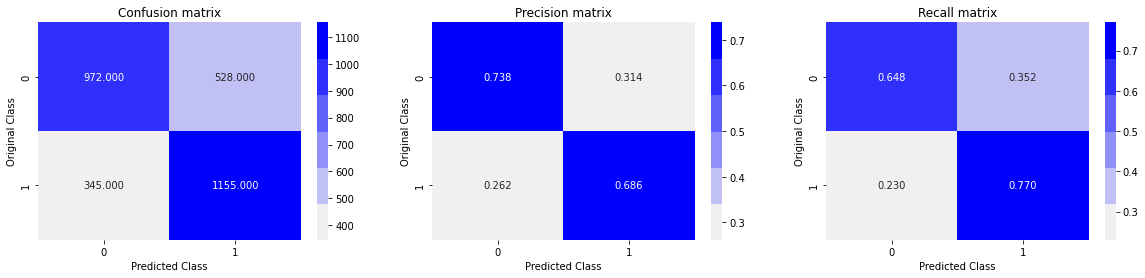

In [ ]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

In [ ]:
print("Classification Report\n",classification_report(y_test,predicted_y))

Classification Report
               precision    recall  f1-score   support

           0       0.74      0.65      0.69      1500
           1       0.69      0.77      0.73      1500

    accuracy                           0.71      3000
   macro avg       0.71      0.71      0.71      3000
weighted avg       0.71      0.71      0.71      3000



##Linear SVM with hyperparameter tuning

For values of alpha =  1e-05 The log loss is: 0.6931471805599454
For values of alpha =  0.0001 The log loss is: 0.621381535179217
For values of alpha =  0.001 The log loss is: 0.5819853788574764
For values of alpha =  0.01 The log loss is: 0.600895987268026
For values of alpha =  0.1 The log loss is: 0.6764261405009229
For values of alpha =  1 The log loss is: 0.6875180781603946
For values of alpha =  10 The log loss is: 0.6931471805599454


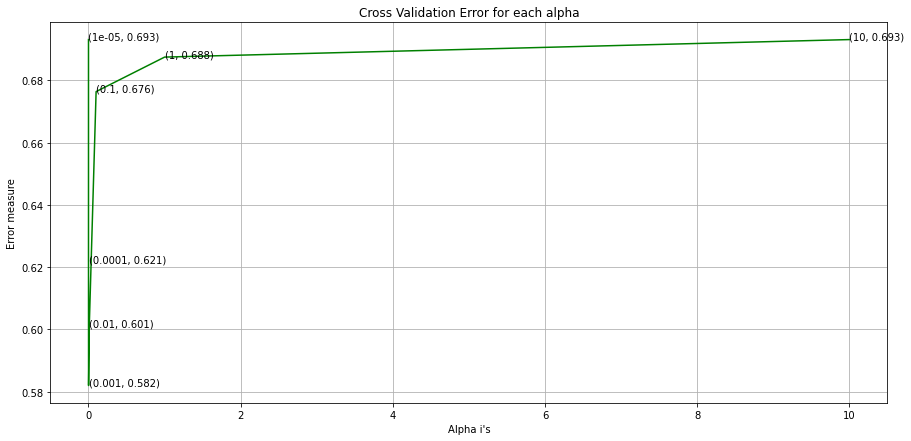

For values of best alpha =  0.001 The train log loss is: 0.5634046307675425
For values of best alpha =  0.001 The test log loss is: 0.5819853788574764
Total number of data points : 3000


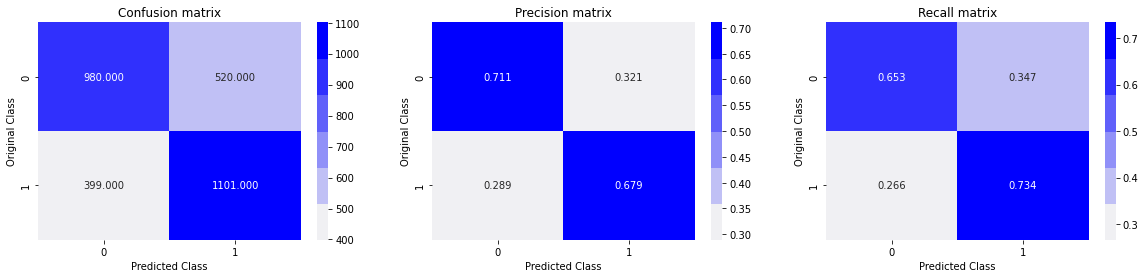

In [ ]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

In [ ]:
print("Classification Report\n",classification_report(y_test,predicted_y))

Classification Report
               precision    recall  f1-score   support

           0       0.71      0.65      0.68      1500
           1       0.68      0.73      0.71      1500

    accuracy                           0.69      3000
   macro avg       0.69      0.69      0.69      3000
weighted avg       0.69      0.69      0.69      3000



##XGboost with hyperparameter tuning

In [ ]:
import xgboost as xgb
param_grid = {"max_depth":[x for x in range(2,10)],
              "n_estimators":[50,100,150,200,300,400,500]}

In [ ]:
model = RandomizedSearchCV(xgb.XGBClassifier(n_jobs=-1,random_state=25), param_distributions=param_grid,n_iter=30,scoring='neg_log_loss',cv=3,n_jobs=-1)

In [ ]:
model.fit(X_train,y_train)

RandomizedSearchCV(cv=3, estimator=XGBClassifier(n_jobs=-1, random_state=25),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9],
                                        'n_estimators': [50, 100, 150, 200, 300,
                                                         400, 500]},
                   scoring='neg_log_loss')

In [ ]:
model.best_params_

{'max_depth': 5, 'n_estimators': 150}

In [ ]:
clf=xgb.XGBClassifier(n_jobs=-1,random_state=25,max_depth=5,n_estimators=150)

In [ ]:
clf.fit(X_train,y_train)

XGBClassifier(max_depth=5, n_estimators=150, n_jobs=-1, random_state=25)

Train log loss =  0.2168446184349554  Test log loss =  0.4365120150013827


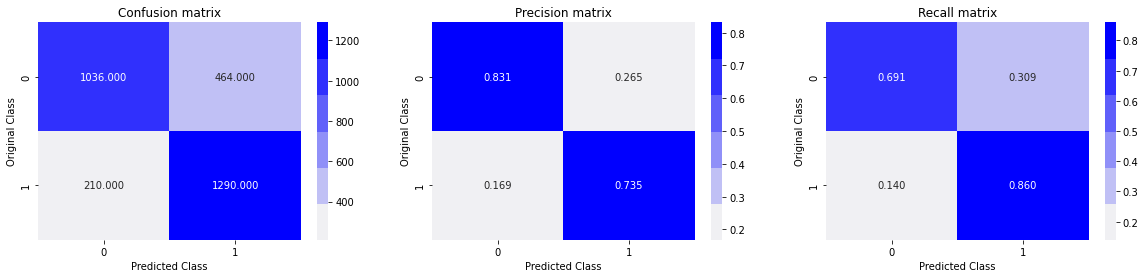

In [ ]:
y_pred_test=clf.predict_proba(X_test)
y_pred_train=clf.predict_proba(X_train)
log_loss_train = log_loss(y_train, y_pred_train, eps=1e-15)
log_loss_test=log_loss(y_test,y_pred_test,eps=1e-15)
print('Train log loss = ',log_loss_train,' Test log loss = ',log_loss_test)
predicted_y=np.argmax(y_pred_test,axis=1)
plot_confusion_matrix(y_test,predicted_y)

In [ ]:
print("Classification Report\n",classification_report(y_test,predicted_y))

Classification Report
               precision    recall  f1-score   support

           0       0.83      0.69      0.75      1500
           1       0.74      0.86      0.79      1500

    accuracy                           0.78      3000
   macro avg       0.78      0.78      0.77      3000
weighted avg       0.78      0.78      0.77      3000



## Results and Evaluation
Since we will be dealing with probability scores, it is best to choose log loss as the metric. Log loss always penalizes small deviations in probability scores. Binary Confusion matrix will provide a number of metrics like TPR, FPR , TNR, FNR, Precision and Recall. Finally, the Classification Report will provide the F1-scores and Accuracy.
<br><br>
**Logistic Regression**
*   The model is not suffering from over fitting since it’s log loss on train and test data are quite close. It may be suffering from high bias or under fitting. 
*   The model is able to predict class 1 decently but slightly under performs in case of class 0.
*   Precision for both classes is not very high.
*   Recall for class 1 is higher than class 0.

<br><br>
**Linear SVM**
*   Similar to the Logistic Regression model, Linear SVM model is not suffering from overfitting since it’s log loss on train and test data are quite close. It may be suffering from high bias or under fitting. 
*   This also faces a similar problem of precision and recall as in Logistic Regression.
*   This model underperforms compared to Logistic Regression as the log loss value is higher and accuracy is lower.
<br><br>

**XGBoost**
*   There is a substantial amount of difference between the training log loss and testing log loss (0.436 - 0.216 = 0.22) which means that our model may be suffering from a problem of overfitting. However, the testing log loss is still better than the other two linear models. 
*   There is an improvement in the precision and recall for both the classes.
*   This means that the model works well for both classes, comparatively, and particularly for class 0.
<br><br>

**XGboost tends to perform much better than the linear model. This indicates that the data is not linearly separable and we need a complex non linear model like XGboost.**






